In [5]:
import sys
sys.path.append('/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages')
sys.path.append('/Users/aakash/anaconda3/lib/python3.6/site-packages')
import ee
import eefuncs as eef
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import warnings
from itertools import product
import time
#import geopandas as gp
plt.rcParams["figure.figsize"] = (15,10)
warnings.filterwarnings('ignore')
ee.Initialize()

In [6]:
sys.path

['',
 '/Users/aakash/anaconda3/lib/python36.zip',
 '/Users/aakash/anaconda3/lib/python3.6',
 '/Users/aakash/anaconda3/lib/python3.6/lib-dynload',
 '/Users/aakash/anaconda3/lib/python3.6/site-packages',
 '/Users/aakash/anaconda3/lib/python3.6/site-packages/aeosa',
 '/Users/aakash/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/aakash/.ipython',
 '/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages',
 '/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages',
 '/Users/aakash/anaconda3/lib/python3.6/site-packages',
 '/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages',
 '/Users/aakash/anaconda3/lib/python3.6/site-packages']

# Define parameters

In [7]:
# Set the Study area (upoad kml to google fusion table, use the DocID in the ft string below)
area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter.eq('id', '107')))
bounds = area.geometry().bounds()


# Set the study years
years = [x for x in range(2000, 2018)] # 2000 - 2015
year = years[-1]

# Landsats and clouds

In [23]:
def get_landsat(year):
    
    '''
    select the appropriate landsat based on operation years 
    '''
    
    landsats = {"L4":ee.ImageCollection('LANDSAT/LT04/C01/T1_SR'), 
            "L5": ee.ImageCollection('LANDSAT/LT05/C01/T1_SR'),
            "L7":ee.ImageCollection('LANDSAT/LE07/C01/T1_SR'),
            "L8":ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")}
    
    if year < 1982 : 
        print("No landsat available")
    if year < 1993 and year > 1982:
        landsat = landsats['L4']
    if year < 2012 and year >1993:
        landsat = landsats['L5']
    else: 
        landsat = landsats['L8']
        
    return landsat

def get_QA_bits(image, start, end, field_name):
    
    '''
    retrieve quality bits from landsat
    '''
    
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
    return image.select([0], [field_name]).bitwiseAnd(pattern).rightShift(start)

def mask_quality(image):
    
    '''
    mask clouds and shoaws from landsat
    '''
    
    QA = image.select('pixel_qa')
    # Get the internal_cloud_algorithm_flag bit.
    shad = get_QA_bits(QA,3,3,'cloud_shadow')
    cloud = get_QA_bits(QA,5,5,'cloud')
    cirrus_detected = get_QA_bits(QA,9,9,'cirrus_detected')
    #Return an image masking out cloudy areas.
    return image.updateMask(shad.eq(0)).updateMask(cloud.eq(0).updateMask(cirrus_detected.eq(0))).unmask()


# Data processing

In [27]:
def array_from_col(col,band,res,bounds=bounds,year=2017,month=1,day=1):
    
    '''
    Transform an ee.ImageCollection class to a numpy array
    '''
    
#     start = ee.Date.fromYMD(year,month,day)
#     end = start.advance(1,'month')
#     col = get_landsat(year).filterBounds(area).filterDate(start, end).map(mask_quality)
    
    # get the lat lon and add the band and scale by the appropriate factor (0.0001 for landsat)
    band_name = col.select(band).median()
    latlon = ee.Image.pixelLonLat().addBands(band_name).multiply(0.0001)

    # apply reducer to list
    latlon = latlon.reduceRegion(
      reducer=ee.Reducer.toList(),
      geometry=bounds,
      maxPixels=1e13,
      scale=res)
    
    data = np.array((ee.Array(latlon.get(band)).getInfo()))
    lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
    lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
    
    arr = array_from_coords(data,lats,lons)
    
    return (arr)

def array_from_coords(data,lats,lons):
    
    '''
    Return a numpy array (ie cartesian product) from lats, lons, and data values
    '''
    
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] 
                
    return arr

# Main

In [28]:
start = ee.Date.fromYMD(year,7,1)
end = start.advance(1,'month')

col = get_landsat(year).filterBounds(bounds).filterDate(start, end).map(mask_quality)

In [29]:
b1 = array_from_col(col,band="B1", res = 100)

In [30]:
b1[b1==0] = np.nan

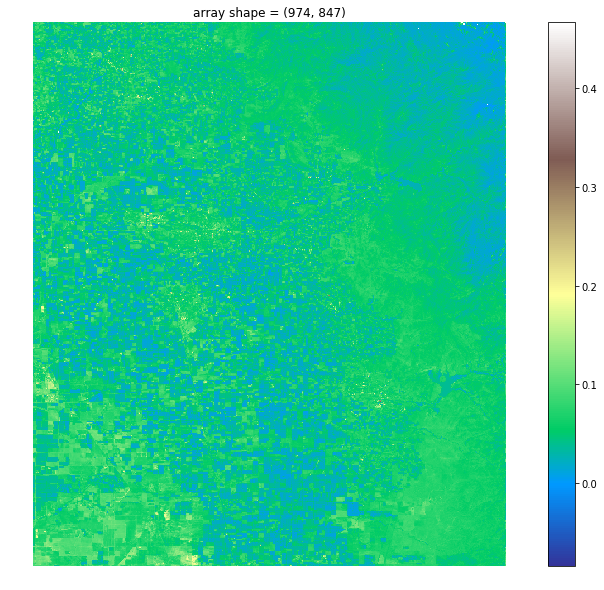

In [31]:
plt.imshow(b1, cmap = "terrain")
plt.title("array shape = {}".format(b1.shape))
plt.axis('off')
plt.colorbar()
plt.show()

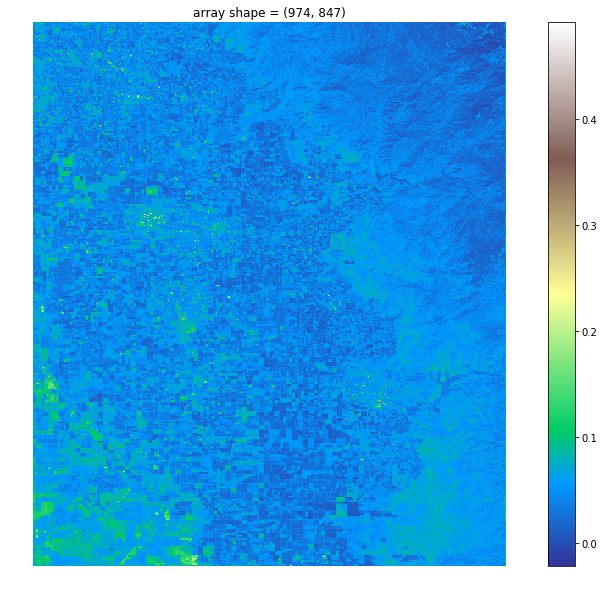

In [37]:
plt.imshow(b1, cmap = "terrain")
plt.title("array shape = {}".format(im.shape))
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
b2 = array_from_col(col,res = 100, band = "B2")

# Chunk the images

In [21]:
def gen_polys(geometry, dx, dy):
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    for lat in latlist.getInfo():
        def make_rect(lat):
            lattemp = ee.Number(lat)
            for lon in lonlist.getInfo():
                lontemp = ee.Number(lon)
                uplattemp = lattemp.subtract(dy)
                lowlontemp = lontemp.add(dx)
                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],
                                                        [lowlontemp, lattemp],
                                                        [lowlontemp, uplattemp],
                                                        [lontemp, uplattemp]]))
    s = latlist.map(make_rect).flatten()       
    
    return s #ee.FeatureCollection(s)

In [53]:
dx, dy = 0.025, 0.025
temp = gen_polys(bounds, dx, dy)
polys = temp.getInfo()

In [54]:
col = get_landsat(year).filterBounds(bounds).filterDate(start,end).map(mask_quality)
arrs = []

for i in polys:
    print(i['geometry']['coordinates'])
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates'])
    arrs.append(array_from_col(col,res = 10, bounds = aoi))
    time.sleep(10)

[[[-122.63771239999998, 38.15965599999998], [-122.61271239999998, 38.15965599999998], [-122.61271239999998, 38.184655999999976], [-122.63771239999998, 38.184655999999976], [-122.63771239999998, 38.15965599999998]]]
[[[-122.63771239999998, 38.184655999999976], [-122.61271239999998, 38.184655999999976], [-122.61271239999998, 38.209655999999974], [-122.63771239999998, 38.209655999999974], [-122.63771239999998, 38.184655999999976]]]
[[[-122.63771239999998, 38.209655999999974], [-122.61271239999998, 38.209655999999974], [-122.61271239999998, 38.23465599999997], [-122.63771239999998, 38.23465599999997], [-122.63771239999998, 38.209655999999974]]]
[[[-122.63771239999998, 38.23465599999998], [-122.61271239999998, 38.23465599999998], [-122.61271239999998, 38.25965599999998], [-122.63771239999998, 38.25965599999998], [-122.63771239999998, 38.23465599999998]]]
[[[-122.63771239999998, 38.25965599999998], [-122.61271239999998, 38.25965599999998], [-122.61271239999998, 38.28465599999998], [-122.6377

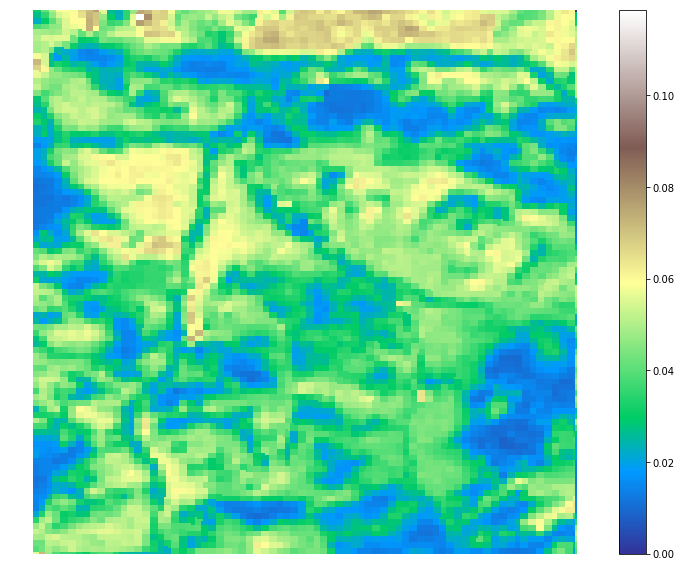

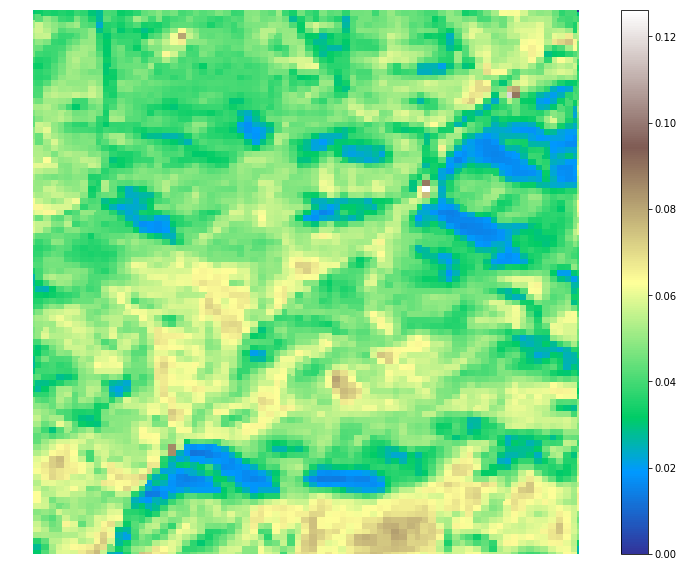

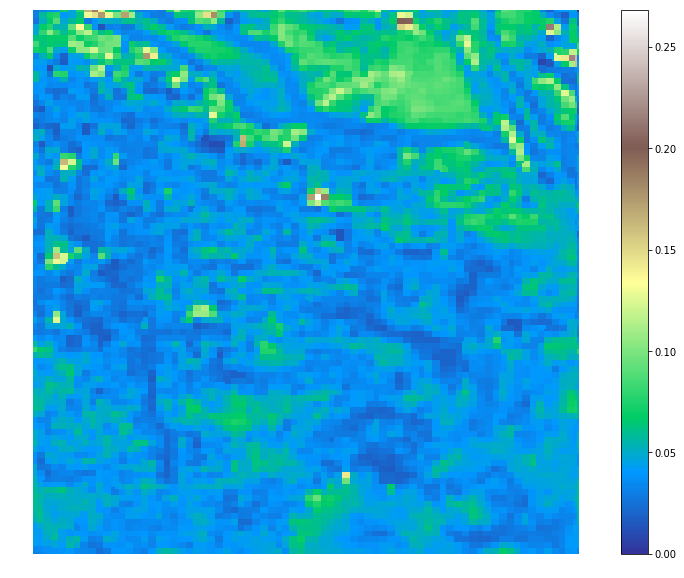

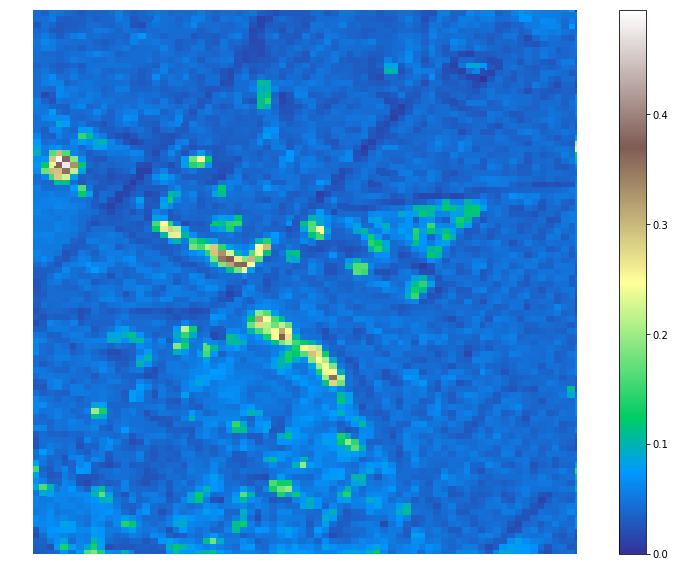

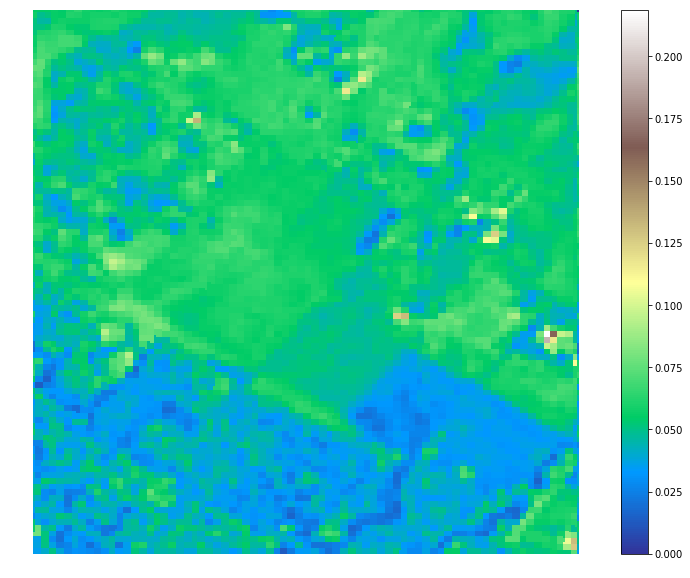

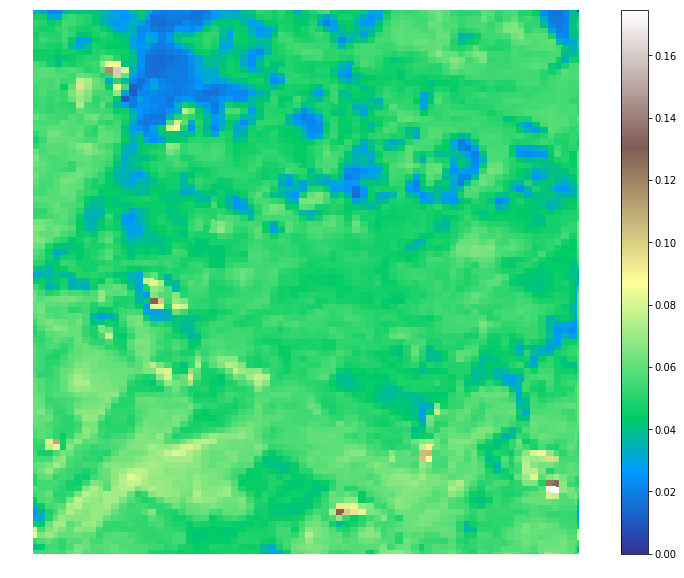

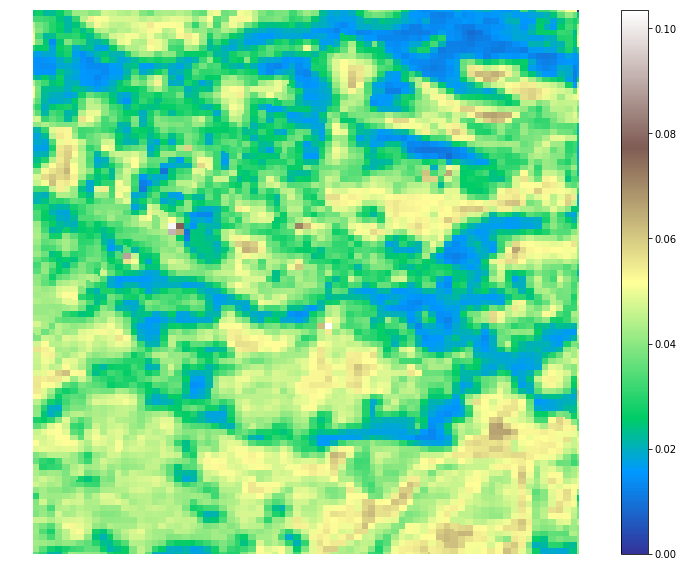

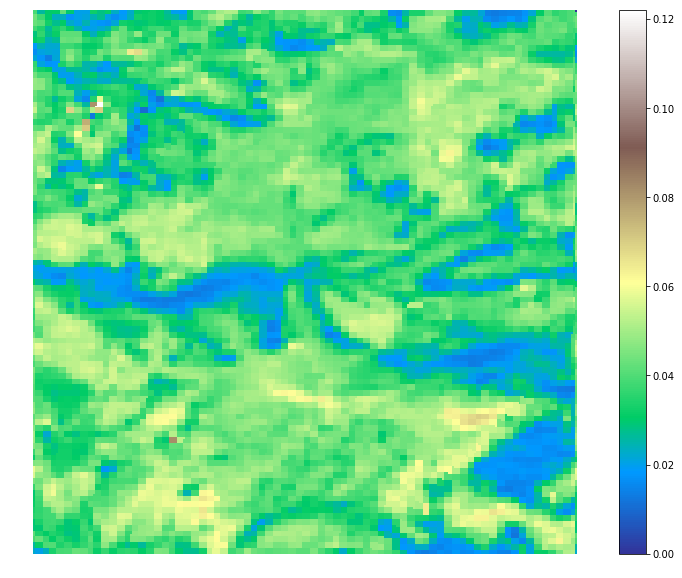

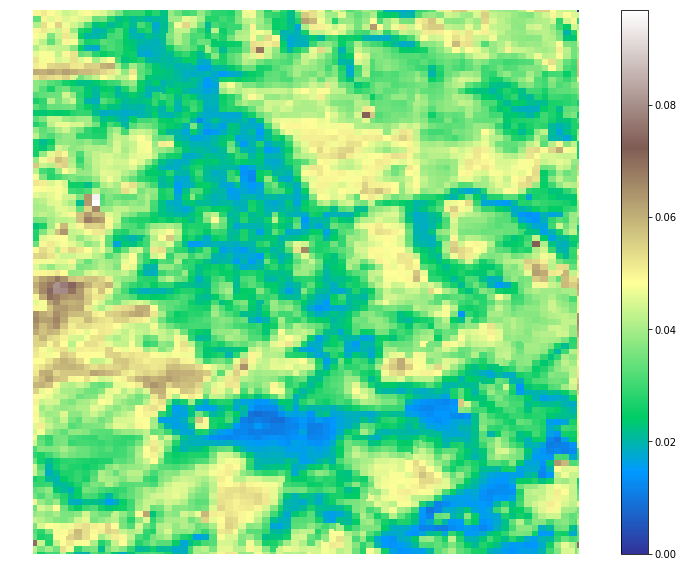

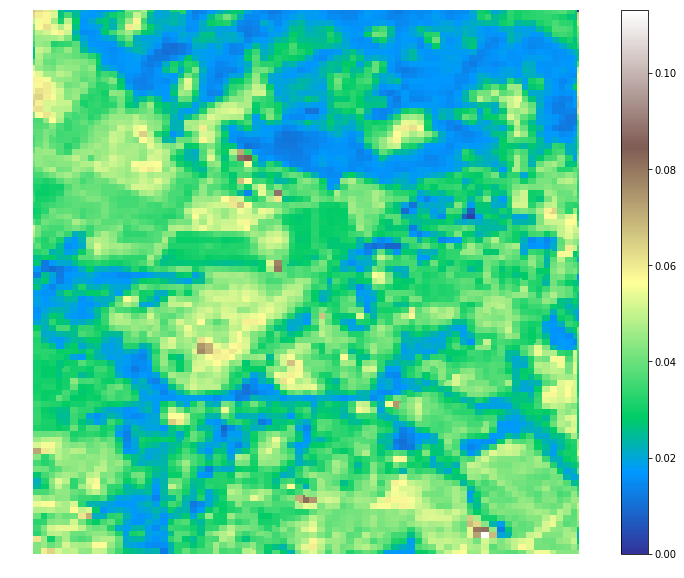

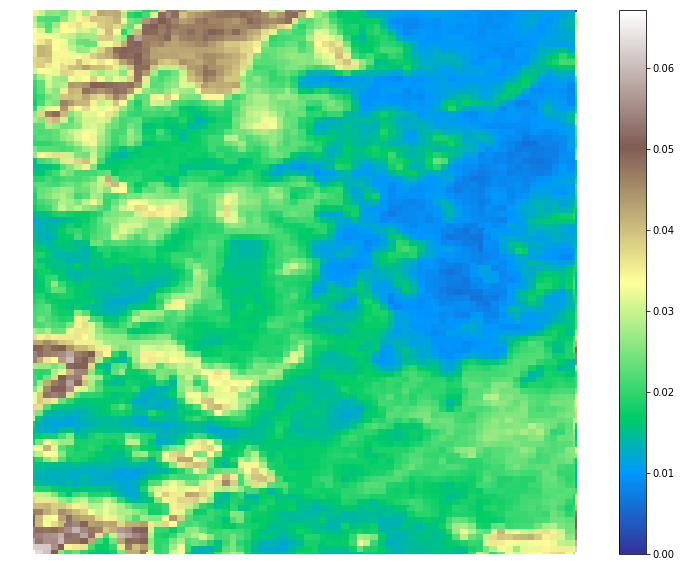

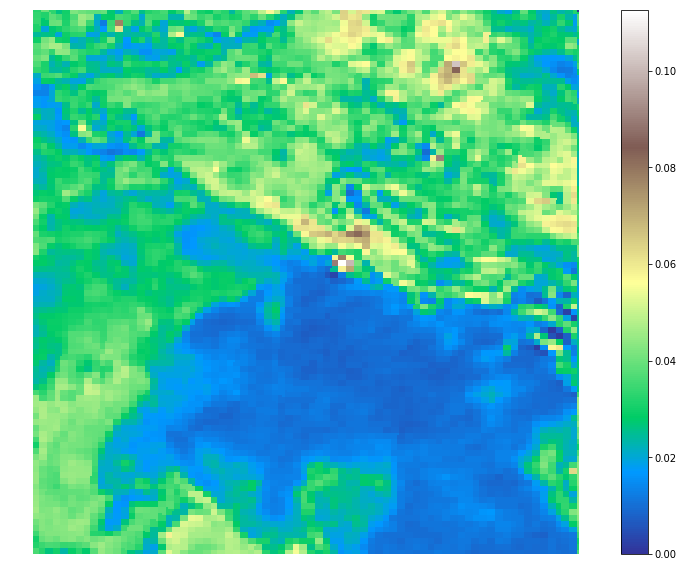

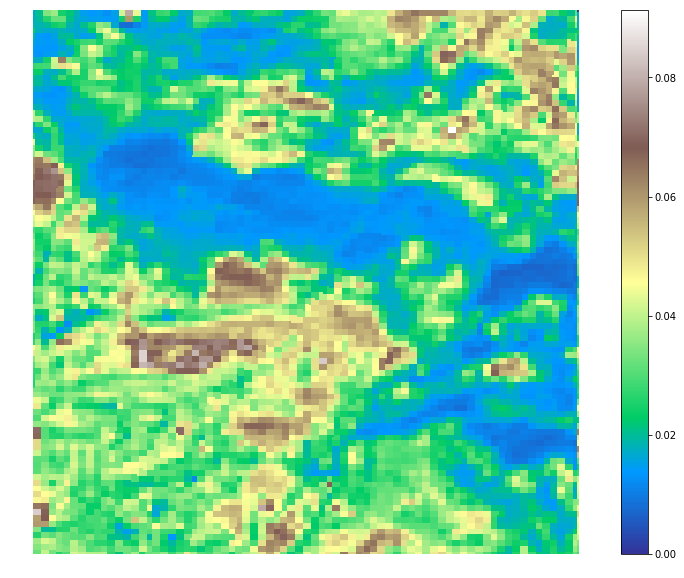

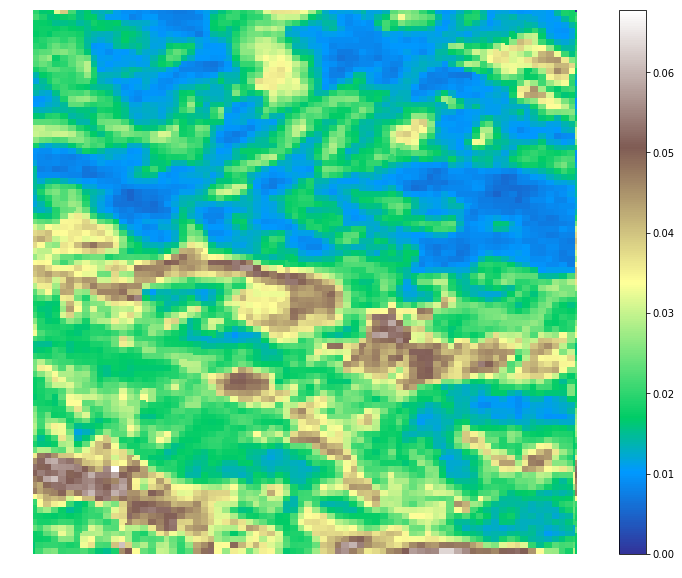

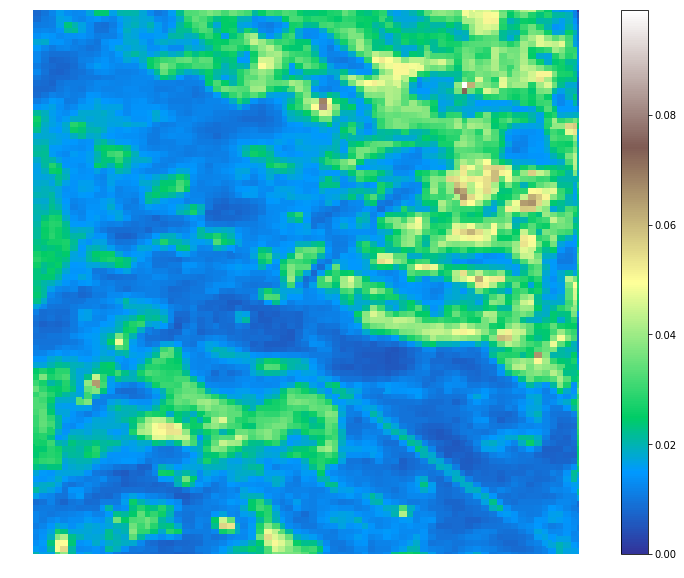

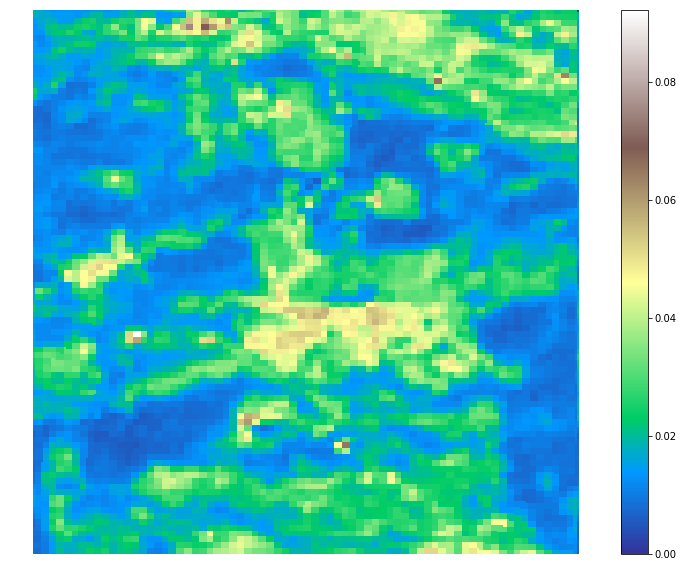

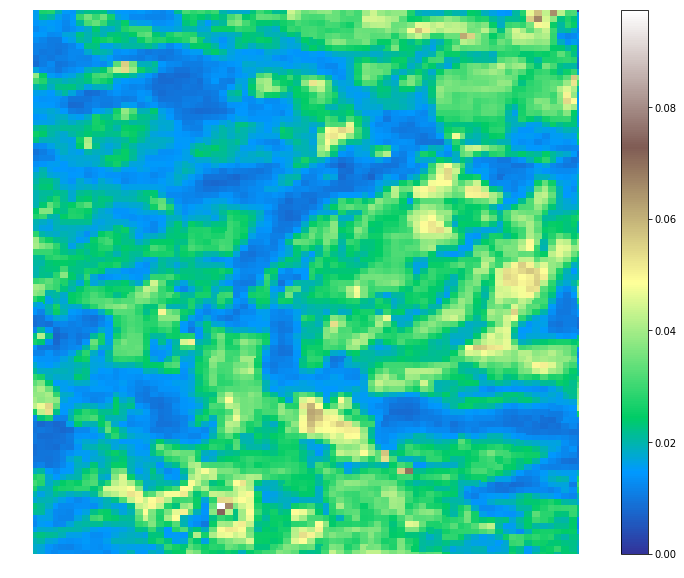

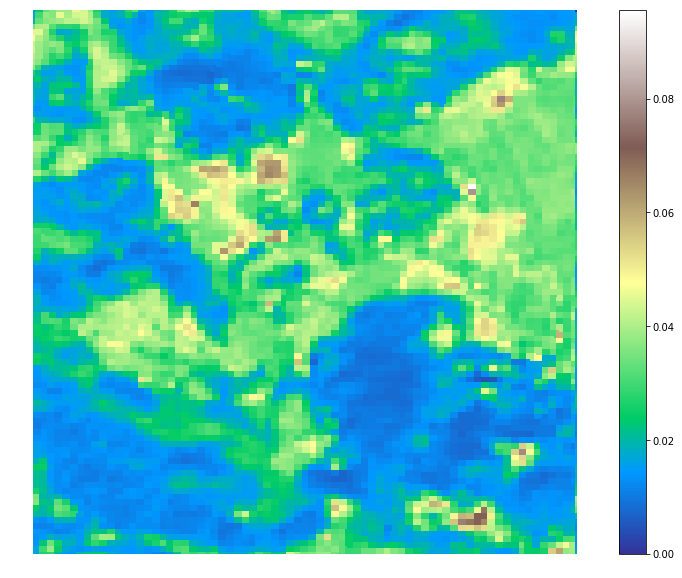

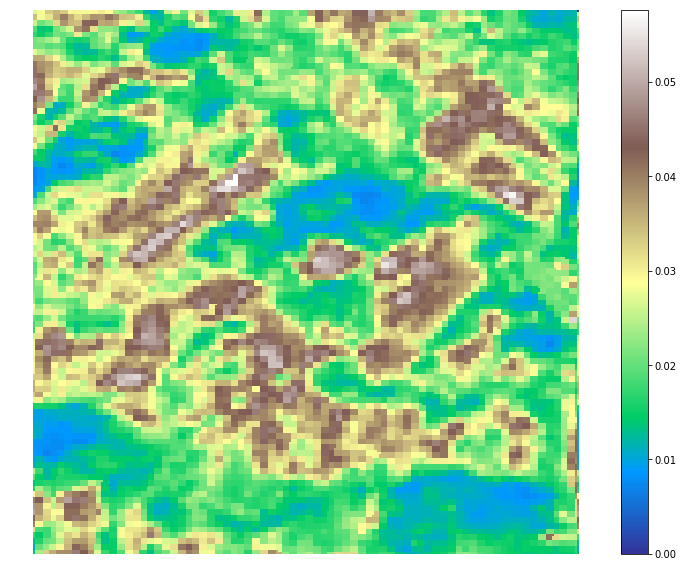

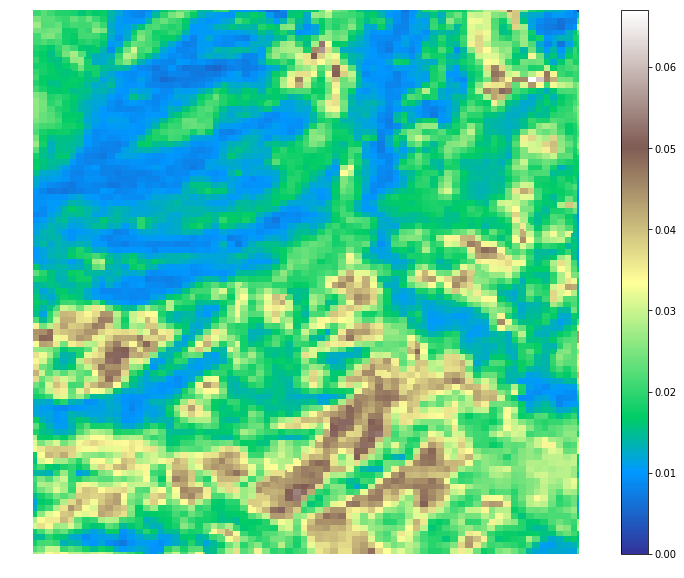

In [55]:
for i in arrs:
    plt.imshow(i, cmap = "terrain")
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Task List:

Short term:
1. Chunk the sentinel grid
2. MODIS cloud masks
3. Filter LS / MODIS by landcover

Longer term: 
1. Modularize
2. Write the code for ET
    a. Pull CIMIS wind speed

Completed: 
1. Chunk grid to get full resolution



In [ ]:
'''
TODO:

1. Chunk grid to get full resolution [X]

2. Try out ee.Reducer.ToCollection
3. MODIS cloud masks 
4. Sentinel (optical) cloud masks and Sentinel Radar 
5. Landcover code 

Make it OOP!!!!

'''

# Sentinel

In [44]:
# Get the RS products
collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(bounds).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).select('VV')
t = collection.filterDate(start, end).mosaic()

In [46]:
im2 = array_from_col(t, res = 70)

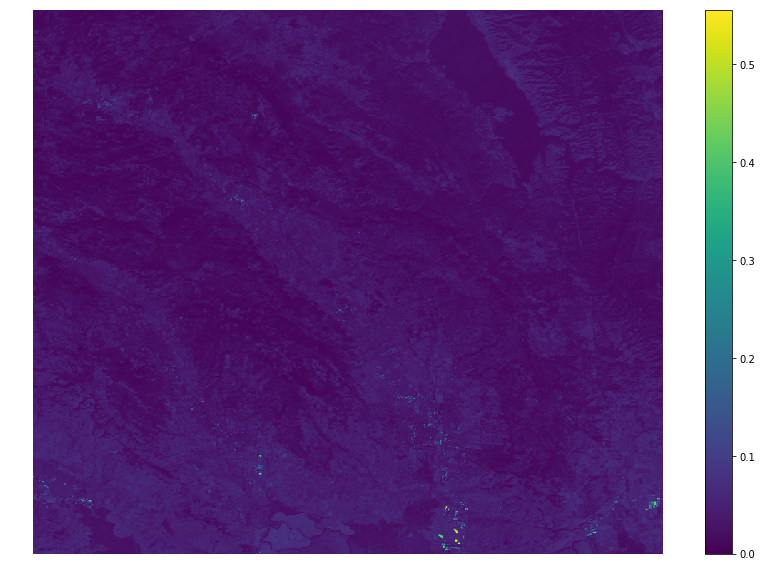

In [47]:
plt.imshow(im2)
plt.axis("off")
plt.colorbar()
plt.show()

In [ ]:
## Chunk check

In [48]:
dx, dy = 0.05, 0.05
temp = gen_polys(bounds, dx, dy)
polys = temp.getInfo()

In [50]:
s1_arrs = []

for i in polys:
    print(i['geometry']['coordinates'])
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates'])
    s1_arrs.append(array_from_col(t,res = 10, bounds = aoi))
    time.sleep(10)

[[[-122.63771239999998, 38.13465599999998], [-122.58771239999999, 38.13465599999998], [-122.58771239999999, 38.184655999999976], [-122.63771239999998, 38.184655999999976], [-122.63771239999998, 38.13465599999998]]]
[[[-122.63771239999998, 38.184655999999976], [-122.58771239999999, 38.184655999999976], [-122.58771239999999, 38.23465599999997], [-122.63771239999998, 38.23465599999997], [-122.63771239999998, 38.184655999999976]]]
[[[-122.63771239999998, 38.23465599999998], [-122.58771239999999, 38.23465599999998], [-122.58771239999999, 38.28465599999998], [-122.63771239999998, 38.28465599999998], [-122.63771239999998, 38.23465599999998]]]
[[[-122.63771239999998, 38.28465599999998], [-122.58771239999999, 38.28465599999998], [-122.58771239999999, 38.334655999999974], [-122.63771239999998, 38.334655999999974], [-122.63771239999998, 38.28465599999998]]]
[[[-122.63771239999998, 38.33465599999998], [-122.58771239999999, 38.33465599999998], [-122.58771239999999, 38.38465599999998], [-122.6377123

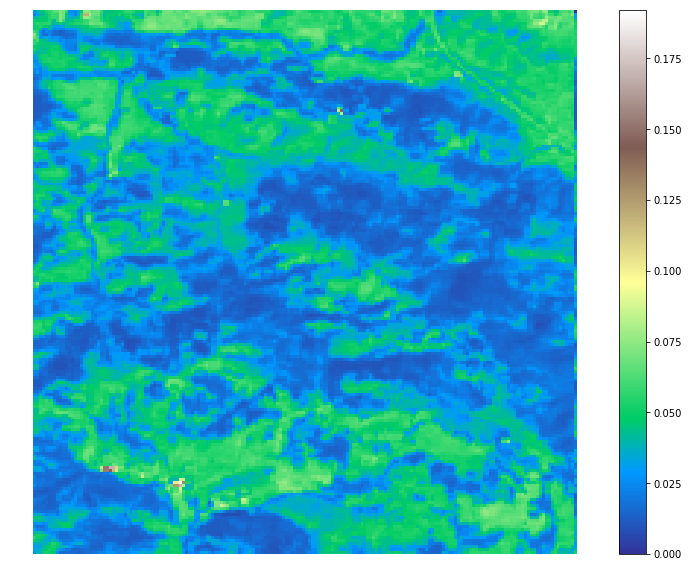

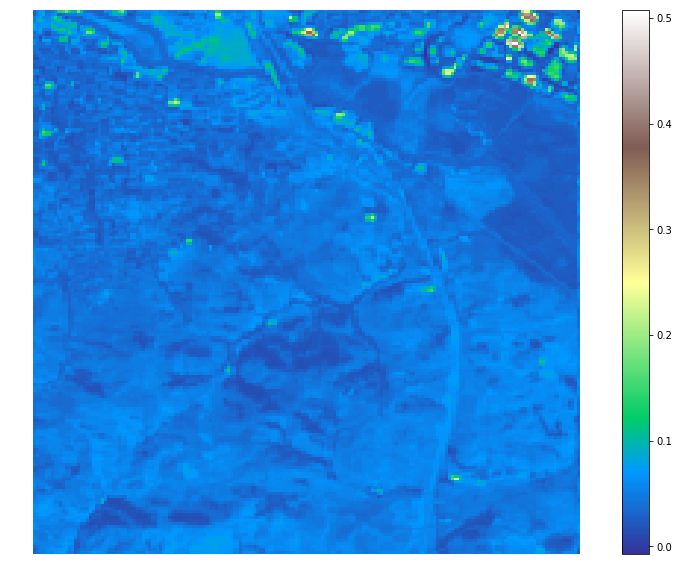

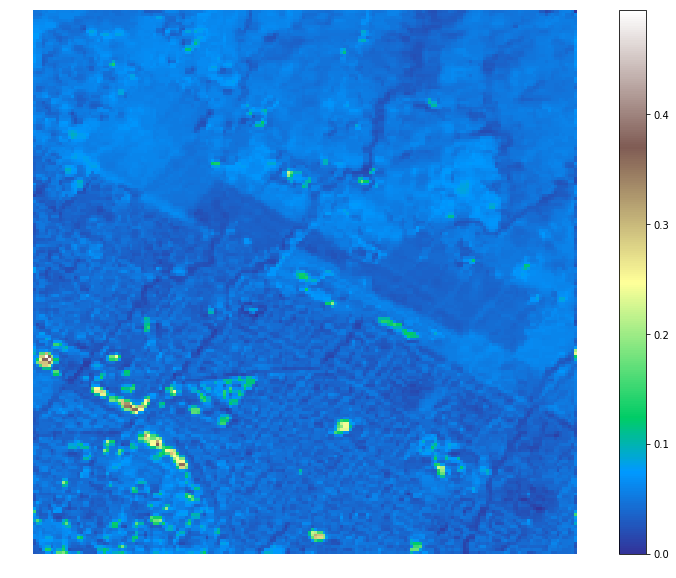

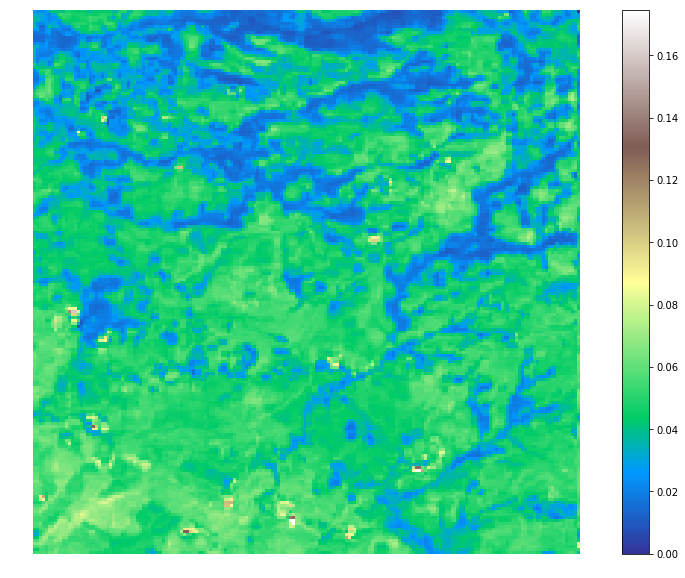

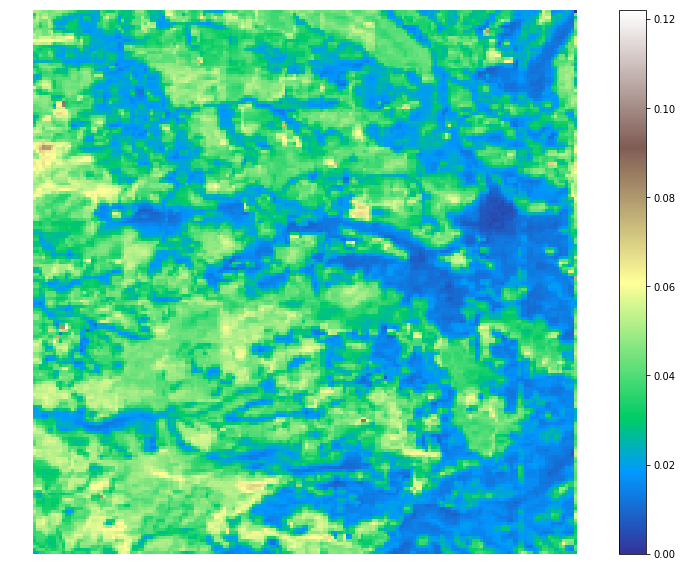

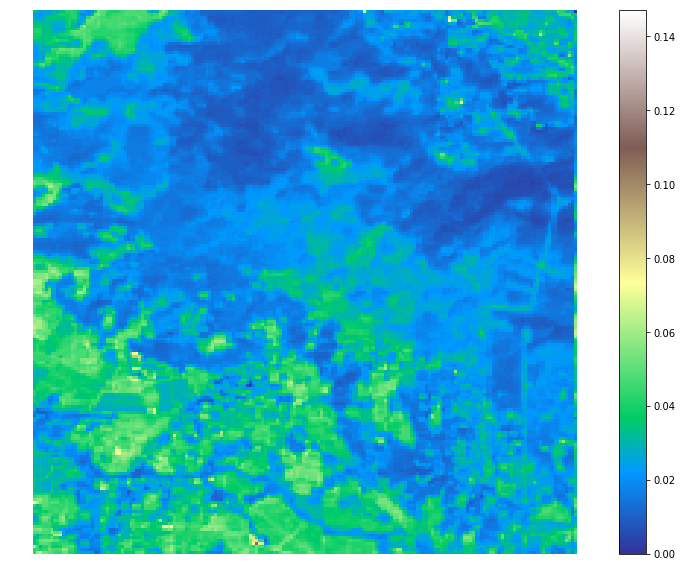

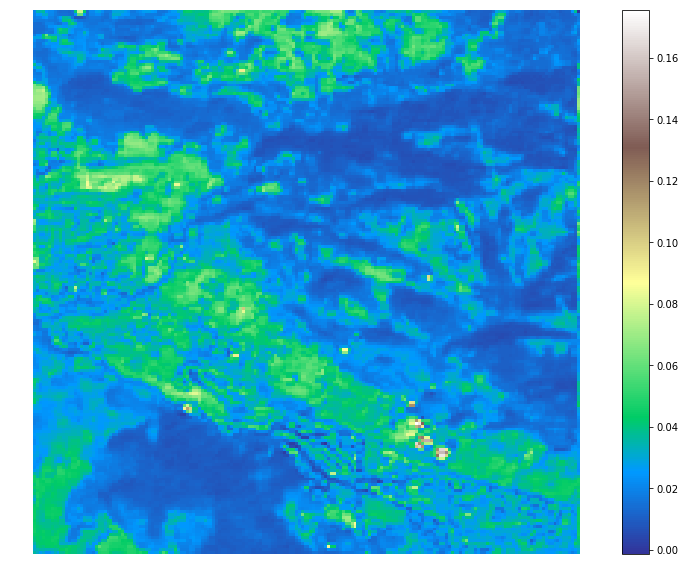

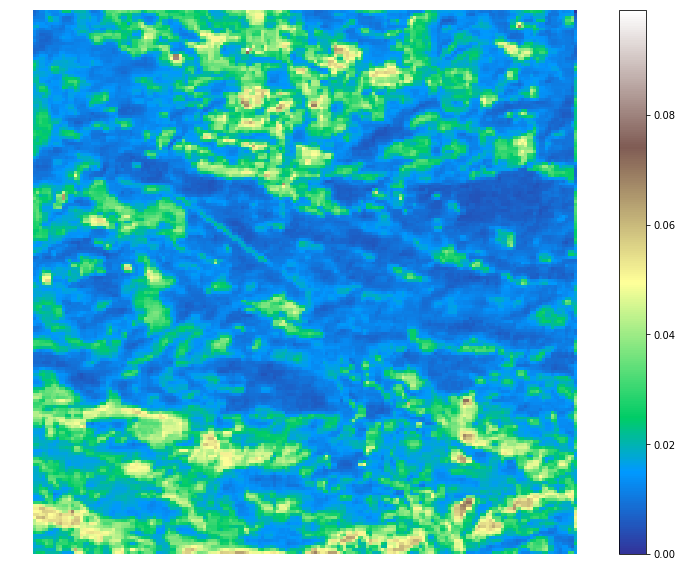

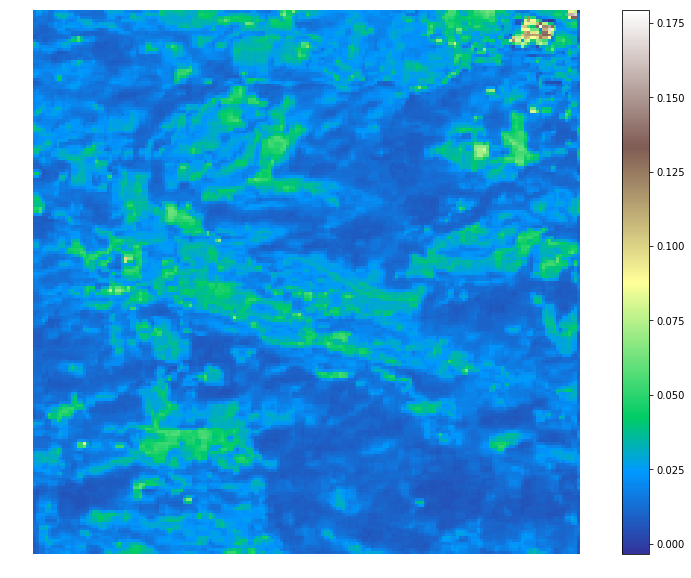

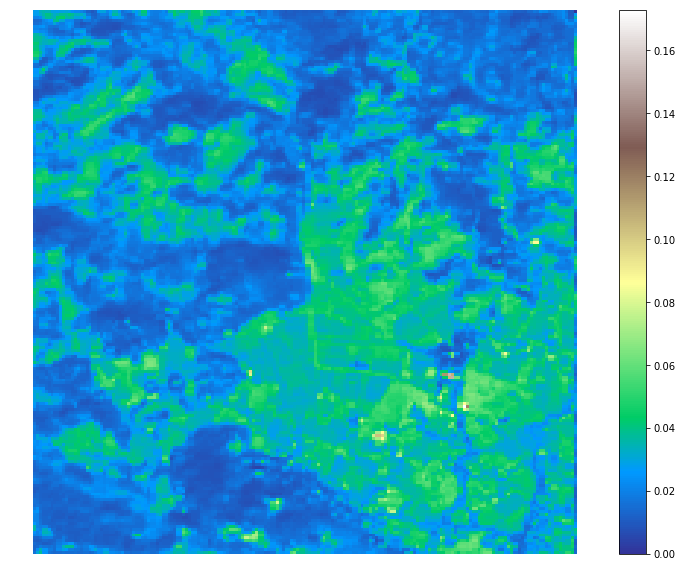

In [51]:
for i in s1_arrs:
    plt.imshow(i, cmap = "terrain")
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [59]:
collection.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'id': 'COPERNICUS/S1_GRD',
 'version': 1537449324857204,
 'properties': {'date_range': [1412294400000.0, 1537315200000.0],
  'period': 0.0,
  'system:visualization_0_min': '-25.0',
  'system:visualization_0_bands': 'VV',
  'thumb': 'https://mw1.google.com/ges/dd/images/s1_thumb.png',
  'description': '<p>The Sentinel-1 mission provides data from a dual-polarization\nC-band Synthetic Aperture Radar (SAR) instrument.  This collection\nincludes the S1 Ground Range Detected (GRD) scenes, processed\nusing the Sentinel-1 Toolbox to generate a calibrated, ortho-corrected\nproduct. The collection is updated weekly.</p>\n<p>This collection\ncontains all of the GRD scenes.  Each scene has one of 3 resolutions\n(10, 25 or 40 meters), 4 band combinations (corresponding to\nscene polarization) and 3 instrument modes.  Use of the collection\nin a mosaic context will likely require filtering down to a homogenous\nset of bands and parameters.  See <a href="ht

# MODIS (done) 

In [ ]:
# Set the study years
year = 2017

In [ ]:
# Set the Study area (upoad kml to google fusion table, use the DocID in the ft string below)
area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter().eq('id', '107')))
bounds = area.geometry().bounds()

# Set the satellite data of interest
modis_ndvi = ee.ImageCollection('MCD43A4_NDVI')
modis_lc = ee.ImageCollection('MODIS/006/MCD12Q1')
modis_sr = ee.ImageCollection('MCD43A4')

In [ ]:
sr = ees.filter_modis_sr(year)
lc = ees.filter_modis_lc(year)

clipped_sr = ee.ImageCollection(sr.clip(bounds))
clipped_lc = ee.ImageCollection(lc.clip(bounds))

lc_out = clipped_lc.getRegion(bounds,250,"epsg:4326").getInfo()
sr_out = clipped_sr.getRegion(bounds,250,"epsg:4326").getInfo()

In [ ]:
tulare = eef.df_from_imcol(sr_out)
tulare_lc = eef.df_from_imcol(lc_out)

In [ ]:
bandnames = ["Nadir_Reflectance_Band1","Nadir_Reflectance_Band2","Nadir_Reflectance_Band3", "Nadir_Reflectance_Band4", "Nadir_Reflectance_Band5","Nadir_Reflectance_Band6", "Nadir_Reflectance_Band7"]

ims = []
for b in bandnames:
    ims.append(eef.array_from_df(tulare,b))

lcs = ["LC_Type1"]
ims.append(eef.array_from_df(tulare_lc,lcs[0]))

# Sanity check

In [ ]:
plt.figure(figsize = (10,10))

for i in range(len(ims)):
    spidx = i+1
    plt.subplot(4,2,spidx)
    try:
        plt.title("{}".format(bandnames[i]))
    except:
        plt.title("crop mask")
    plt.imshow(ims[i])
    plt.axis("off")
    plt.colorbar()
    
plt.tight_layout()
plt.show()

In [ ]:
# Grab the training data 
cwd = os.getcwd() #os.path.split(os.getcwd())[0]
y_dir = [os.path.join(cwd,x) for x in os.listdir(cwd) if "yield" in x][0]
fn = [os.path.join(y_dir,x) for x in os.listdir(y_dir) if "107" in x][0]

d = json.load(open(fn))
yrs = [str(x) for x in years]
d_2 = { year: d[year] for year in yrs }
training = d_2.values()

In [ ]:
features = np.array([np.ndarray.flatten(x) for x in ims])
labels = np.array(training)

# Test ML methods

In [ ]:
# Train / Test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 10)

# NN naming convention
X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Simple NN

In [ ]:
def ff_nn(X_train):
    model = Sequential()
    model.add(Dense(85, input_dim=33150, activation='relu'))
    model.add(Dense(42, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
    
    return model

In [ ]:
# Visualize loss functions
plot_callback = PlotLossesKeras()

# Fit model
model = ff_nn(X_train)
model.fit(X_train, y_train, validation_data=[test_features,test_labels],epochs=300,verbose=1, callbacks = [plot_callback])

In [ ]:
predictions = model.predict(X_test).reshape(predictions.shape[0])
mape = 100. * (np.abs((predictions - y_test) / y_test))
np.mean(mape)

# Random Forest

In [ ]:
# Instantiate, train, predict 
rf = RandomForestRegressor(n_estimators= 10000)#, random_state=50)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)

# rf_new = RandomForestRegressor(n_estimators = 500, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)

In [ ]:
# Median Absolute Percentage Error Function
mape = 100 * (np.abs(((predictions) - (test_labels)) / (test_labels)))

print('Median Absolute Percentage Error: {} %'.format(str(round(np.median(mape), 2))))

In [ ]:
s = rf.feature_importances_
s.reshape(arrs[0].shape)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(s.reshape(arrs[0].shape))
plt.colorbar()


plt.subplot(1,2,2)
plt.imshow(arrs[0])

plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
arrs[0].shape